Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

In [ ]:
!pip install -q numpy pandas matplotlib seaborn 
!pip install -q torchvision

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import re
import time



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\diana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\diana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Save and load model

In [3]:
# Utility functions for saving and loading models
import os
import pickle

def save_model(model, filename, directory='saved_models'):
    """Save a model to disk
    Args:
        model: The model to save
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to save in (will be created if it doesn't exist)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    filepath = os.path.join(directory, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def load_model(filename, directory='saved_models'):
    """Load a model from disk
    Args:
        filename: Name of the file (will add .pkl if not present)
        directory: Directory to load from
    Returns:
        The loaded model
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
        
    filepath = os.path.join(directory, filename)
    if not os.path.exists(filepath):
        print(f"No saved model found at {filepath}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filepath}")
    return model

# Task 1: Acquire the data

In [ ]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()
print((mean_train, std_train))

# normalize train_dataset & test_dataset
mlp_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_normalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform)
test_dataset_normalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_normalized))
val_size = len(full_train_dataset_normalized) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_normalized, val_dataset_normalized = random_split(full_train_dataset_normalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False, generator=generator)

# sanity check
x, y = next(iter(train_loader))
print((x.shape, y.shape)) # expect [64, 784] and [64]
input_size = x.shape[1]
output_size = len(set(full_train_dataset_normalized.targets.numpy()))
print(input_size, output_size)

(0.2860405743122101, 0.3530242443084717)
(torch.Size([64, 784]), torch.Size([64]))
784 10


# Task 2: Implement a Multilayer Perceptron

## Accuracy Score

In [5]:
def evaluate_acc(true, pred):
  return np.sum(true == pred) / len(true)

## Activation Functions

In [6]:
class relu:
  def activation(self, x):
    return np.maximum(0, x)
  def derivative(self, x):
    return np.where(x > 0, 1, 0)

class leakyRelu:
  def __init__(self, gamma=0.01):
    self.gamma = gamma
  def activation(self, x):
    return np.where(x > 0, x, self.gamma * x)
  def derivative(self, x):
    return np.where(x > 0, 1, self.gamma)

class sigmoid:
  def activation(self, x):
    return 1 / (1 + np.exp(-x))
  def derivative(self, x):
    return self.activation(x) * (1 - self.activation(x))

class tanh:
  def activation(self, x):
    return np.tanh(x)
  def derivative(self, x):
    return 1 - np.tanh(x) ** 2

class softmax:
  def activation(self, x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    total = np.sum(exp_x, axis=1, keepdims=True)
    return exp_x / total
  def derivative(self, x):
    return self.activation(x) * (1 - self.activation(x))


## MLP

In [ ]:
def softmax(X):
  exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
  return exp_X / np.sum(exp_X, axis=1, keepdims=True)

# implementing the MLP class
class MLP:

  def __init__(self, activation_function, num_hidden_layers, units, seed=42):
    self.seed = seed
    self.activation_function = activation_function
    self.num_hidden_layers = num_hidden_layers
    self.units = units

    # initialize weights and biases
    self.layer_sizes = [input_size] + units + [output_size]
    self.L = num_hidden_layers + 1  # Number of layers (excluding input) (input is 0 indexed)
    self.weights = []
    self.biases = []
    self.activations = {}
    self.z_values = {}
    self.loss_history = []
    self.accuracy_history = []
    self.test_accuracy_history = []

    self.results = []
    np.random.seed(self.seed)
    for i in range(len(self.layer_sizes)-1): 
      w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * np.sqrt(2/self.layer_sizes[i])
      b = np.zeros((1, self.layer_sizes[i+1]))
      self.weights.append(w)
      self.biases.append(b)
      
    self.grad_weights = {}
    self.grad_biases = {}

    self.lambda_l1 = 0
    self.lambda_l2 = 0

  def forward_propagation(self, X):
    # Forward propagation through the network
    self.activations[0] = X
    previous_activation = X
    # Hidden layers
    for l in range(self.L):
        W = self.weights[l]
        b = self.biases[l]

        Z = np.dot(previous_activation, W) + b
        # Activation for Layer L (last layer)
        if l == self.L - 1:
          A = softmax(Z)
        else:
          A = self.activation_function.activation(Z)

        self.z_values[l+1] = Z
        self.activations[l+1] = A
        previous_activation = A

    # Sums to 1 as it is softmax
    return previous_activation

  def backward_propagation(self, AL, X, Y):
    m = Y.shape[0]
    num_layers = self.L
    dZ = AL - Y

    for l in reversed(range(num_layers)):
      if l == 0:
        previous_activation = X
      else:
        previous_activation = self.activations[l]
      W = self.weights[l]

      self.grad_weights[l] = np.dot(previous_activation.T, dZ) / m
      self.grad_biases[l] = np.sum(dZ, axis=0, keepdims=True) / m

      # Add regularization gradients
      self.grad_weights[l] += (self.lambda_l1 * np.sign(W) + 2 * self.lambda_l2 * W) / m

      if l > 0:
        # Compute gradient for previous layer
        dA_prev = np.dot(dZ, W.T)
        Z_prev = self.z_values[l]
        dZ = dA_prev * self.activation_function.derivative(Z_prev)


  def update_parameters(self):
    for l in range(self.L):
      self.weights[l] -= self.learning_rate * self.grad_weights[l]
      self.biases[l] -= self.learning_rate * self.grad_biases[l]


  def compute_loss(self, AL, Y):
    """Compute cross-entropy loss"""
    m = Y.shape[0]

    # Clip probabilities to avoid log(0)
    epsilon = 1e-15
    AL = np.clip(AL, epsilon, 1 - epsilon)

    # Cross-entropy loss
    cross_entropy = -np.sum(Y * np.log(AL)) / m

    # L1 and L2 regularization terms
    l1_reg = self.lambda_l1 * sum(np.sum(np.abs(w)) for w in self.weights) / (2 * m)
    l2_reg = self.lambda_l2 * sum(np.sum(w**2) for w in self.weights) / (2 * m)

    total_loss = cross_entropy + l1_reg + l2_reg

    return total_loss
  
  def compute_accuracy(self, true, pred):
    predictions = np.argmax(pred, axis=1)
    labels = np.argmax(true, axis=1)
    accuracy = np.mean(predictions == labels)
    return accuracy


  def fit(self, train_loader, test_loader, learning_rate, epochs, lambda_l1=0.0, lambda_l2=0.0):
    start_epoch = 0

    self.accuracy_history = []
    self.loss_history = []
    self.test_accuracy_history = []

    np.random.seed(self.seed)
    self.lambda_l1 = lambda_l1
    self.lambda_l2 = lambda_l2
    self.learning_rate = learning_rate
    for epoch in range(start_epoch, epochs):
      epoch_loss = 0
      n_batches = 0
      epoch_accuracy = 0

      for X_batch, y_batch in train_loader:
        X_batch_np = X_batch.numpy()
        y_batch_onehot = np.eye(output_size)[y_batch.numpy()] # One-hot encode labels

        # Forward propagation
        AL = self.forward_propagation(X_batch_np)

        # Compute loss and accuracy
        loss = self.compute_loss(AL, y_batch_onehot)
        accuracy = self.compute_accuracy(y_batch_onehot, AL)
        epoch_loss += loss
        epoch_accuracy += accuracy
        n_batches += 1

        # Backward propagation
        self.backward_propagation(AL, X_batch_np, y_batch_onehot)

        # Update parameters
        self.update_parameters()

      avg_loss = epoch_loss / n_batches
      avg_accuracy = epoch_accuracy / n_batches
      self.loss_history.append(avg_loss)
      self.accuracy_history.append(avg_accuracy)

      # Calculate test accuracy
      all_y_true_test = []
      all_y_pred_test = []
      for X_batch_test, y_batch_test in test_loader:
          X_batch_test_np = X_batch_test.numpy()
          y_batch_test_np = y_batch_test.numpy()
          y_pred_test = self.predict(X_batch_test_np)
          all_y_true_test.extend(y_batch_test_np)
          all_y_pred_test.extend(y_pred_test)
      test_accuracy = evaluate_acc(np.array(all_y_true_test), np.array(all_y_pred_test))
      self.test_accuracy_history.append(test_accuracy)
      result_string = f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}"
      self.results.append(result_string)
      print(result_string)


  def predict(self, X):
    """Make predictions"""
    AL = self.forward_propagation(X)
    predictions = np.argmax(AL, axis=1)
    return predictions

  def plot_history(self):
    """Plots the training loss and accuracy history."""
    epochs = range(1, len(self.loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, self.loss_history, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, self.accuracy_history, 'ro-', label='Training Accuracy')
    plt.plot(epochs, self.test_accuracy_history, 'go-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Task 3: Run the experiments and report

## 3.1: MLPs with Different Depths

Model loaded from saved_models\model1.1.pkl


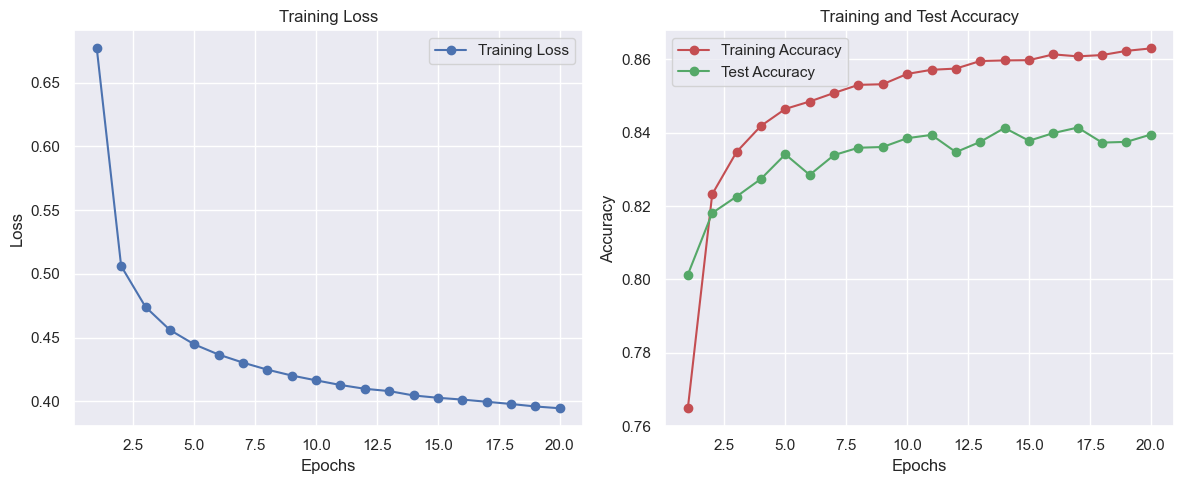

In [44]:
# Model 1 - No hidden layers, ReLU activation
model1 = load_model('model1.1')
if model1 is None: 
    model1 = MLP(activation_function=relu(), num_hidden_layers=0, units=[])
    model1.fit(train_loader, test_loader, 0.01, 20) 
    model1.plot_history()
    save_model(model1, 'model1.1')
else: 
    model1.plot_history()

Model loaded from saved_models\model1.2.pkl


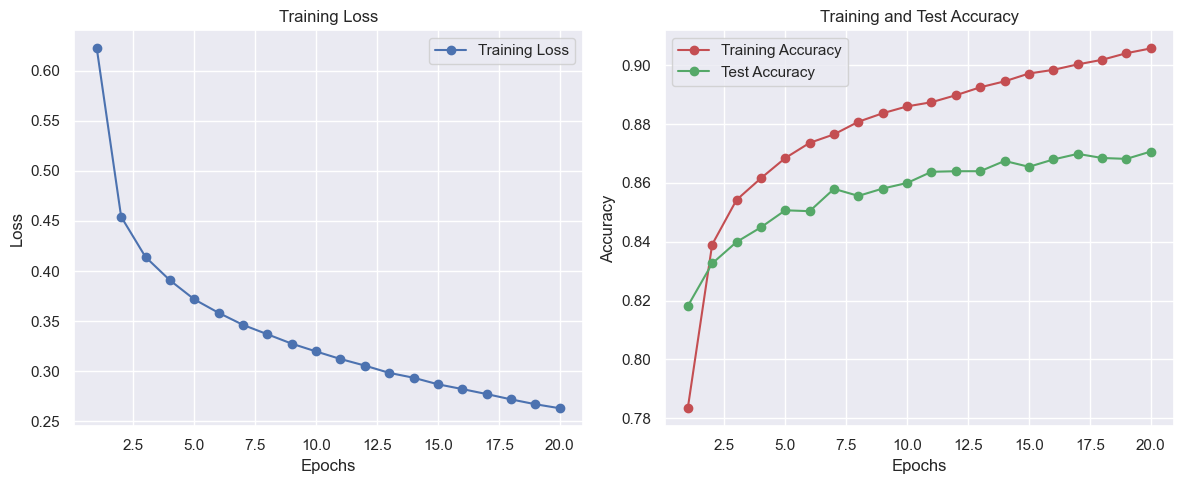

In [43]:
# Model 2 - One hidden layer with 256 units, ReLU activation
model2 = load_model('model1.2')
if model2 is None: 
    model2 = MLP(activation_function=relu(), num_hidden_layers=1, units=[256])
    model2.fit(train_loader, test_loader, 0.01, 20) 
    model2.plot_history()
    save_model(model2, 'model1.2')
else: 
    model2.plot_history()

No saved model found at saved_models\model1.3.pkl
Epoch 1/20, Loss: 0.6067, Train Accuracy: 0.7850, Test Accuracy: 0.8188
Epoch 2/20, Loss: 0.4299, Train Accuracy: 0.8447, Test Accuracy: 0.8374
Epoch 3/20, Loss: 0.3868, Train Accuracy: 0.8609, Test Accuracy: 0.8482
Epoch 4/20, Loss: 0.3628, Train Accuracy: 0.8687, Test Accuracy: 0.8527
Epoch 5/20, Loss: 0.3435, Train Accuracy: 0.8760, Test Accuracy: 0.8583
Epoch 6/20, Loss: 0.3282, Train Accuracy: 0.8811, Test Accuracy: 0.8590
Epoch 7/20, Loss: 0.3162, Train Accuracy: 0.8853, Test Accuracy: 0.8508
Epoch 8/20, Loss: 0.3044, Train Accuracy: 0.8891, Test Accuracy: 0.8613
Epoch 9/20, Loss: 0.2952, Train Accuracy: 0.8930, Test Accuracy: 0.8675
Epoch 10/20, Loss: 0.2851, Train Accuracy: 0.8971, Test Accuracy: 0.8686
Epoch 11/20, Loss: 0.2775, Train Accuracy: 0.8986, Test Accuracy: 0.8701
Epoch 12/20, Loss: 0.2694, Train Accuracy: 0.9013, Test Accuracy: 0.8667
Epoch 13/20, Loss: 0.2637, Train Accuracy: 0.9042, Test Accuracy: 0.8698
Epoch 14/2

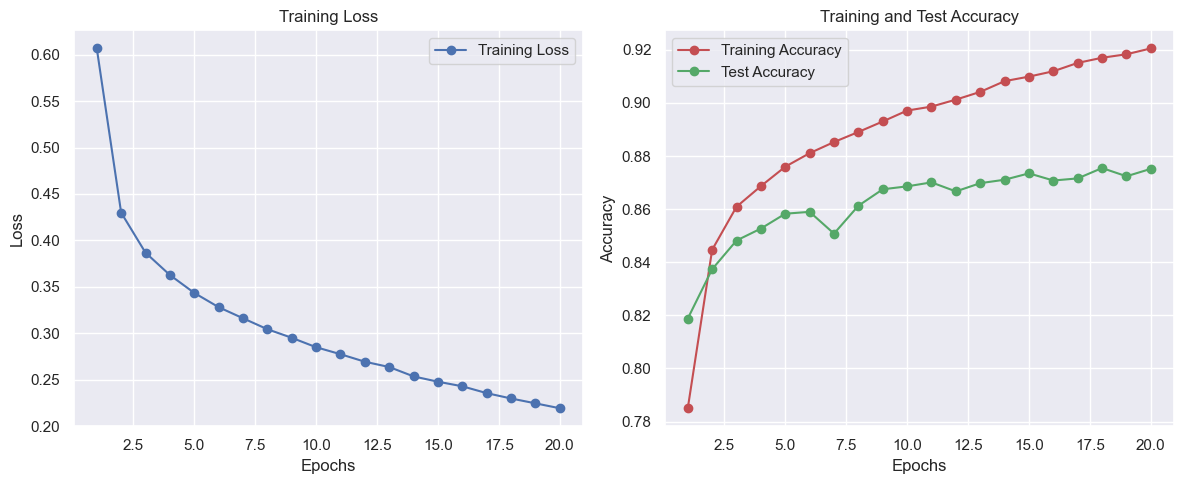

Model saved to saved_models\model1.3.pkl


In [45]:
# Model 3 - Two hidden layers with 256 units each, ReLU activation
model3 = load_model('model1.3')
if model3 is None: 
    model3 = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model3.fit(train_loader, test_loader, 0.01, 20) 
    model3.plot_history()
    save_model(model1, 'model1.3')
else: 
    model3.plot_history()

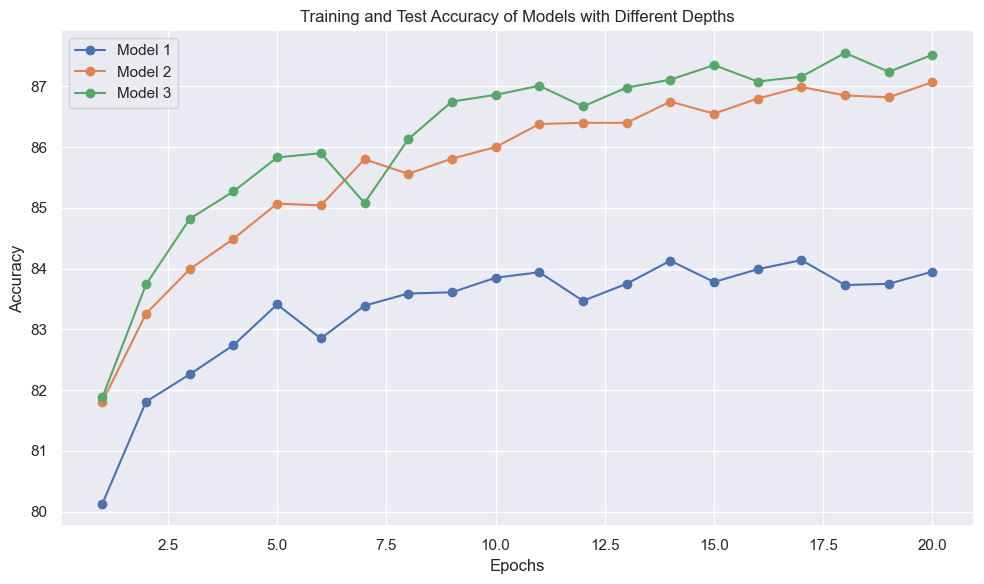

In [47]:
# Comparison of models test accuracy
models = [('Model 1', model1), ('Model 2', model2), ('Model 3', model3)]
plt.figure(figsize=(10, 6))
for model_name, model in models:
    epochs = range(1, len(model.loss_history) + 1)
    plt.plot(epochs, [a*100 for a in model.test_accuracy_history], marker='o', label=model_name)
plt.title('Training and Test Accuracy of Models with Different Depths')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.2: Activation Function Comparison

Model loaded from saved_models/init_2_256_256_relu.pkl
Model loaded from saved_models/fit_2_256_256_relu_0.01_0.0_0.0.pkl
25
Loaded trained model from cache.
Epoch 1/20, Loss: 0.6068, Train Accuracy: 0.7855, Test Accuracy: 0.8165
Epoch 2/20, Loss: 0.4290, Train Accuracy: 0.8449, Test Accuracy: 0.8413
Epoch 3/20, Loss: 0.3886, Train Accuracy: 0.8594, Test Accuracy: 0.8477
Epoch 4/20, Loss: 0.3624, Train Accuracy: 0.8687, Test Accuracy: 0.8545
Epoch 5/20, Loss: 0.3443, Train Accuracy: 0.8754, Test Accuracy: 0.8570
Epoch 6/20, Loss: 0.3283, Train Accuracy: 0.8810, Test Accuracy: 0.8609
Epoch 7/20, Loss: 0.3170, Train Accuracy: 0.8850, Test Accuracy: 0.8634
Epoch 8/20, Loss: 0.3048, Train Accuracy: 0.8883, Test Accuracy: 0.8662
Epoch 9/20, Loss: 0.2952, Train Accuracy: 0.8928, Test Accuracy: 0.8673
Epoch 10/20, Loss: 0.2860, Train Accuracy: 0.8955, Test Accuracy: 0.8686
Epoch 11/20, Loss: 0.2779, Train Accuracy: 0.8997, Test Accuracy: 0.8694
Epoch 12/20, Loss: 0.2694, Train Accuracy: 0.902

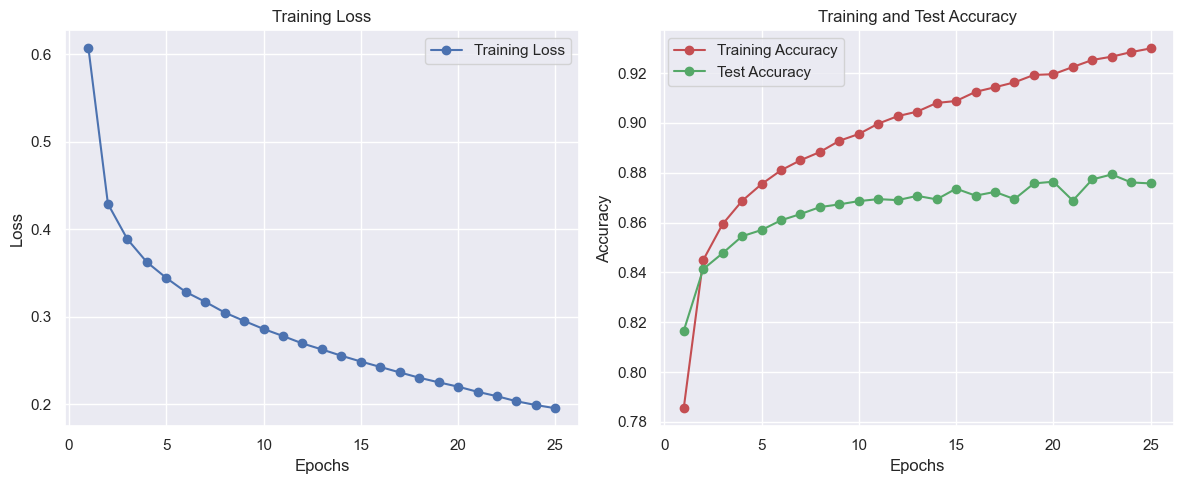

In [ ]:
# Copy of model with 2 hidden layers with tanh activation function
model3_tanh = load_model('model2.1')
if model3_tanh is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_tanh = copy.deepcopy(model3_ReLU)
        model3_tanh.activation_function = tanh() # type: ignore
        model3_tanh.fit(train_loader, test_loader, 0.01, 20)
        model3_tanh.plot_history()
        save_model(model3_tanh, 'model2.1')
else: 
    model3_tanh.plot_history()

In [ ]:
# Copy of model with 2 hidden layers with leaky ReLU activation function
model3_leakyReLU = load_model('model2.2')
if model3_leakyReLU is None:
    model3_ReLU = load_model('model1.3')
    if model3_ReLU is not None: 
        model3_leakyReLU = copy.deepcopy(model3_ReLU)
        model3_leakyReLU.activation_function = leakyRelu() # type: ignore
        model3_leakyReLU.fit(train_loader, test_loader, 0.01, 20)
        model3_leakyReLU.plot_history()
        save_model(model3_leakyReLU, 'model2.2')
else: 
    model3_leakyReLU.plot_history()

No saved model found at saved_models/fit_2_256_256_leakyRelu_0.01_0.0_0.0.pkl
Epoch 1/20, Loss: 0.1905, Train Accuracy: 0.9328, Test Accuracy: 0.8763
Epoch 2/20, Loss: 0.1854, Train Accuracy: 0.9336, Test Accuracy: 0.8741


KeyboardInterrupt: 

In [ ]:
# ???
#model3_40epochs = copy.deepcopy(model3)
#model3_40epochs.fit(train_loader, test_loader, 0.01, 20)
#model3_40epochs.plot_history()

Epoch 1/20, Loss: 0.2111, Train Accuracy: 0.9249, Test Accuracy: 0.8787
Epoch 2/20, Loss: 0.2067, Train Accuracy: 0.9267, Test Accuracy: 0.8801
Epoch 3/20, Loss: 0.2012, Train Accuracy: 0.9289, Test Accuracy: 0.8804
Epoch 4/20, Loss: 0.1966, Train Accuracy: 0.9309, Test Accuracy: 0.8811
Epoch 5/20, Loss: 0.1916, Train Accuracy: 0.9334, Test Accuracy: 0.8833
Epoch 6/20, Loss: 0.1873, Train Accuracy: 0.9333, Test Accuracy: 0.8823
Epoch 7/20, Loss: 0.1826, Train Accuracy: 0.9358, Test Accuracy: 0.8828
Epoch 8/20, Loss: 0.1788, Train Accuracy: 0.9369, Test Accuracy: 0.8786
Epoch 9/20, Loss: 0.1745, Train Accuracy: 0.9391, Test Accuracy: 0.8785
Epoch 10/20, Loss: 0.1693, Train Accuracy: 0.9405, Test Accuracy: 0.8814
Epoch 11/20, Loss: 0.1668, Train Accuracy: 0.9422, Test Accuracy: 0.8819
Epoch 12/20, Loss: 0.1620, Train Accuracy: 0.9440, Test Accuracy: 0.8846
Epoch 13/20, Loss: 0.1582, Train Accuracy: 0.9464, Test Accuracy: 0.8808
Epoch 14/20, Loss: 0.1541, Train Accuracy: 0.9475, Test Accu

## 3.3: L1 and L2 Regularization

In [83]:
lambda_ranges = np.concatenate((np.array([0]), np.logspace(-4, 0, 5)))

In [1]:
for l in lambda_ranges:
    model = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model.fit(train_loader, test_loader, 0.01, 10, lambda_l1=l)
    model.plot_history()

NameError: name 'lambda_ranges' is not defined

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6074, Train Accuracy: 0.7855, Test Accuracy: 0.8208
Epoch 2/10, Loss: 0.4294, Train Accuracy: 0.8441, Test Accuracy: 0.8417
Epoch 3/10, Loss: 0.3872, Train Accuracy: 0.8601, Test Accuracy: 0.8401
Epoch 4/10, Loss: 0.3633, Train Accuracy: 0.8683, Test Accuracy: 0.8479
Epoch 5/10, Loss: 0.3441, Train Accuracy: 0.8751, Test Accuracy: 0.8554
Epoch 6/10, Loss: 0.3283, Train Accuracy: 0.8801, Test Accuracy: 0.8569
Epoch 7/10, Loss: 0.3159, Train Accuracy: 0.8847, Test Accuracy: 0.8637
Epoch 8/10, Loss: 0.3047, Train Accuracy: 0.8887, Test Accuracy: 0.8642
Epoch 9/10, Loss: 0.2951, Train Accuracy: 0.8931, Test Accuracy: 0.8618
Epoch 10/10, Loss: 0.2858, Train Accuracy: 0.8969, Test Accuracy: 0.8654


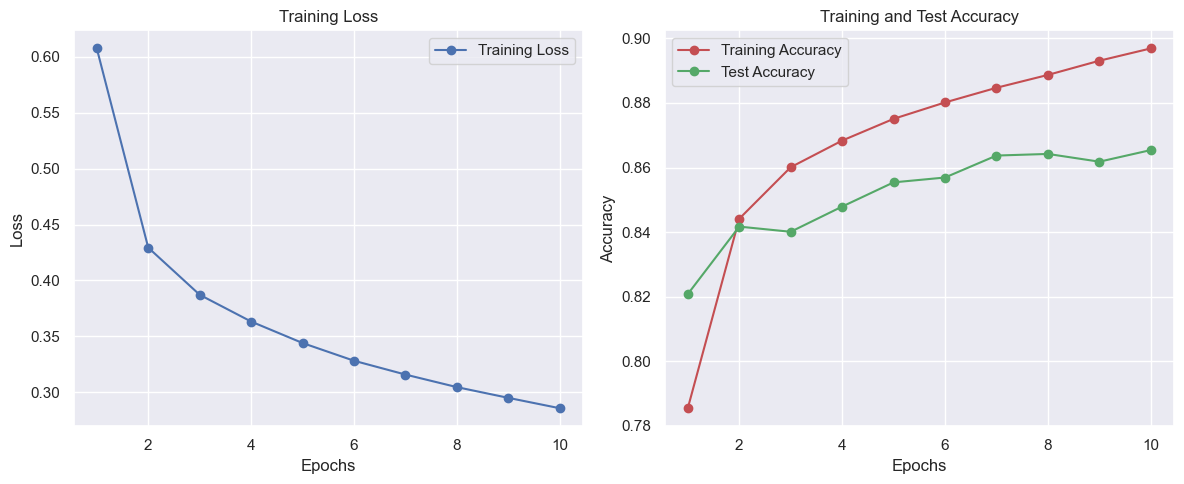

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.0001.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6079, Train Accuracy: 0.7862, Test Accuracy: 0.8225
Epoch 2/10, Loss: 0.4304, Train Accuracy: 0.8453, Test Accuracy: 0.8398
Epoch 3/10, Loss: 0.3881, Train Accuracy: 0.8600, Test Accuracy: 0.8466
Epoch 4/10, Loss: 0.3643, Train Accuracy: 0.8673, Test Accuracy: 0.8489
Epoch 5/10, Loss: 0.3448, Train Accuracy: 0.8750, Test Accuracy: 0.8545
Epoch 6/10, Loss: 0.3310, Train Accuracy: 0.8817, Test Accuracy: 0.8545
Epoch 7/10, Loss: 0.3167, Train Accuracy: 0.8854, Test Accuracy: 0.8608
Epoch 8/10, Loss: 0.3054, Train Accuracy: 0.8888, Test Accuracy: 0.8553
Epoch 9/10, Loss: 0.2962, Train Accuracy: 0.8924, Test Accuracy: 0.8657
Epoch 10/10, Loss: 0.2865, Train Accuracy: 0.8960, Test Accuracy: 0.8658


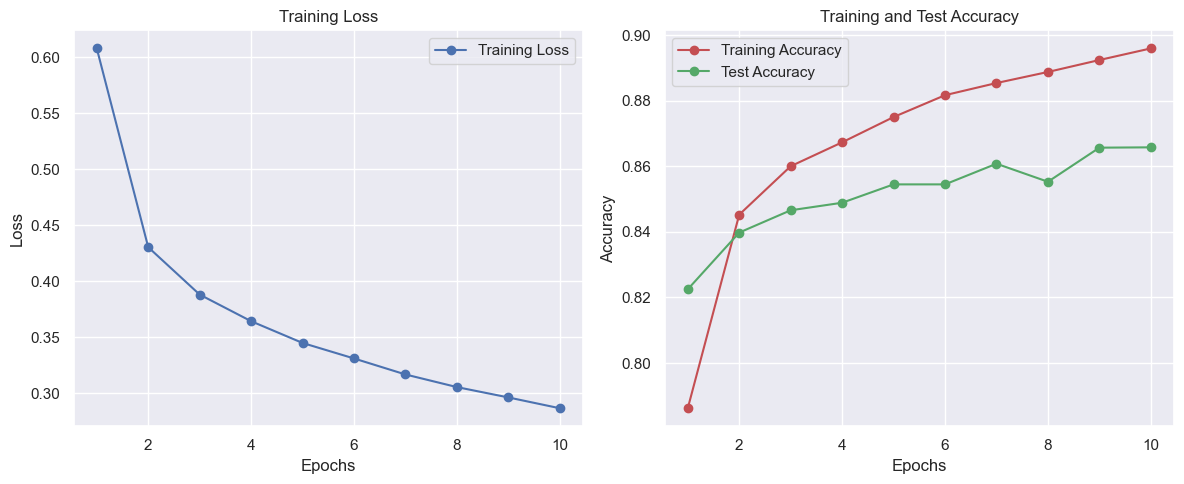

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.001.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6151, Train Accuracy: 0.7846, Test Accuracy: 0.8221
Epoch 2/10, Loss: 0.4382, Train Accuracy: 0.8450, Test Accuracy: 0.8393
Epoch 3/10, Loss: 0.3951, Train Accuracy: 0.8600, Test Accuracy: 0.8438
Epoch 4/10, Loss: 0.3707, Train Accuracy: 0.8692, Test Accuracy: 0.8549
Epoch 5/10, Loss: 0.3526, Train Accuracy: 0.8755, Test Accuracy: 0.8534
Epoch 6/10, Loss: 0.3375, Train Accuracy: 0.8806, Test Accuracy: 0.8582
Epoch 7/10, Loss: 0.3251, Train Accuracy: 0.8840, Test Accuracy: 0.8629
Epoch 8/10, Loss: 0.3143, Train Accuracy: 0.8874, Test Accuracy: 0.8623
Epoch 9/10, Loss: 0.3035, Train Accuracy: 0.8932, Test Accuracy: 0.8610
Epoch 10/10, Loss: 0.2947, Train Accuracy: 0.8958, Test Accuracy: 0.8667


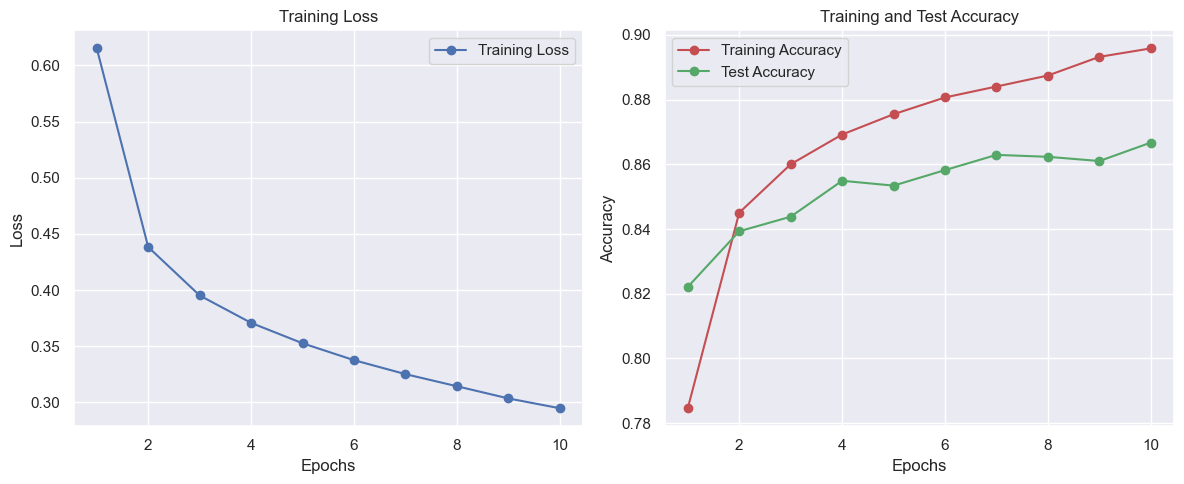

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.01.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 0.6919, Train Accuracy: 0.7839, Test Accuracy: 0.8158
Epoch 2/10, Loss: 0.5131, Train Accuracy: 0.8440, Test Accuracy: 0.8360
Epoch 3/10, Loss: 0.4701, Train Accuracy: 0.8595, Test Accuracy: 0.8392
Epoch 4/10, Loss: 0.4450, Train Accuracy: 0.8680, Test Accuracy: 0.8546
Epoch 5/10, Loss: 0.4261, Train Accuracy: 0.8739, Test Accuracy: 0.8564
Epoch 6/10, Loss: 0.4112, Train Accuracy: 0.8808, Test Accuracy: 0.8593
Epoch 7/10, Loss: 0.3978, Train Accuracy: 0.8858, Test Accuracy: 0.8604
Epoch 8/10, Loss: 0.3862, Train Accuracy: 0.8888, Test Accuracy: 0.8637
Epoch 9/10, Loss: 0.3772, Train Accuracy: 0.8919, Test Accuracy: 0.8662
Epoch 10/10, Loss: 0.3683, Train Accuracy: 0.8953, Test Accuracy: 0.8653


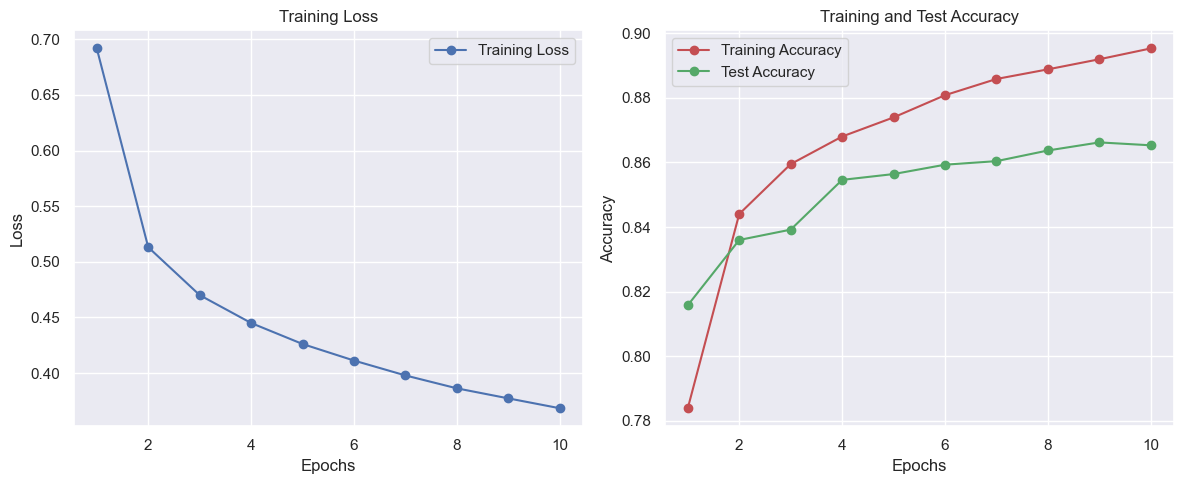

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_0.1.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 1.4091, Train Accuracy: 0.7869, Test Accuracy: 0.8131
Epoch 2/10, Loss: 1.1976, Train Accuracy: 0.8438, Test Accuracy: 0.8374
Epoch 3/10, Loss: 1.1256, Train Accuracy: 0.8584, Test Accuracy: 0.8499
Epoch 4/10, Loss: 1.0707, Train Accuracy: 0.8667, Test Accuracy: 0.8497
Epoch 5/10, Loss: 1.0241, Train Accuracy: 0.8723, Test Accuracy: 0.8531
Epoch 6/10, Loss: 0.9838, Train Accuracy: 0.8778, Test Accuracy: 0.8554
Epoch 7/10, Loss: 0.9457, Train Accuracy: 0.8819, Test Accuracy: 0.8614
Epoch 8/10, Loss: 0.9116, Train Accuracy: 0.8846, Test Accuracy: 0.8591
Epoch 9/10, Loss: 0.8790, Train Accuracy: 0.8874, Test Accuracy: 0.8636
Epoch 10/10, Loss: 0.8494, Train Accuracy: 0.8904, Test Accuracy: 0.8637


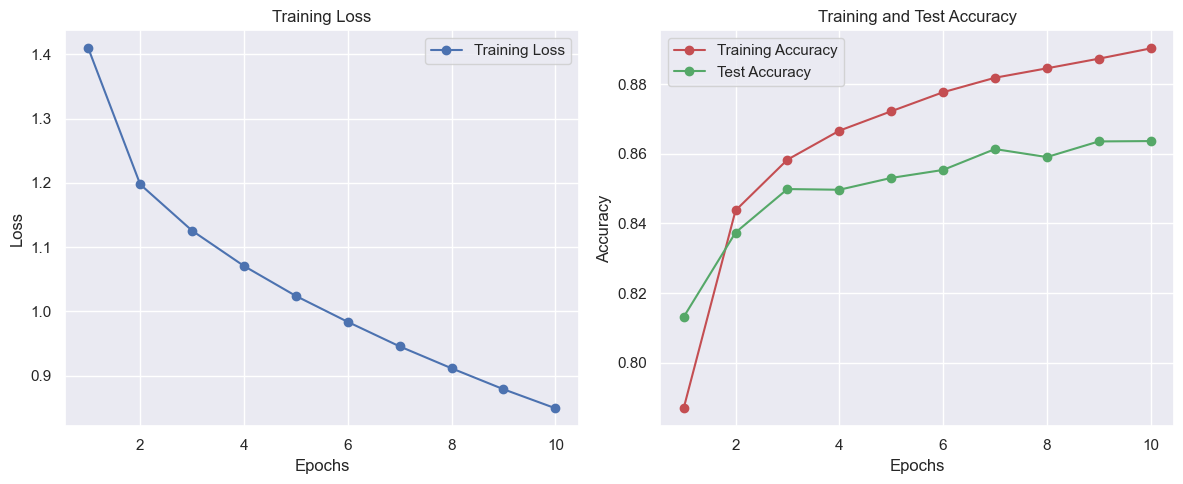

Model loaded from saved_models\init_2_256_256_relu.pkl
Model loaded from saved_models\fit_2_256_256_relu_0.01_10_0.0_1.0.pkl
Loaded trained model from cache.
Epoch 1/10, Loss: 7.1646, Train Accuracy: 0.7820, Test Accuracy: 0.8082
Epoch 2/10, Loss: 4.6225, Train Accuracy: 0.8328, Test Accuracy: 0.8290
Epoch 3/10, Loss: 3.1138, Train Accuracy: 0.8409, Test Accuracy: 0.8209
Epoch 4/10, Loss: 2.1797, Train Accuracy: 0.8430, Test Accuracy: 0.8294
Epoch 5/10, Loss: 1.6004, Train Accuracy: 0.8423, Test Accuracy: 0.8290
Epoch 6/10, Loss: 1.2403, Train Accuracy: 0.8410, Test Accuracy: 0.8313
Epoch 7/10, Loss: 1.0147, Train Accuracy: 0.8418, Test Accuracy: 0.8267
Epoch 8/10, Loss: 0.8743, Train Accuracy: 0.8411, Test Accuracy: 0.8288
Epoch 9/10, Loss: 0.7854, Train Accuracy: 0.8413, Test Accuracy: 0.8293
Epoch 10/10, Loss: 0.7300, Train Accuracy: 0.8401, Test Accuracy: 0.8257


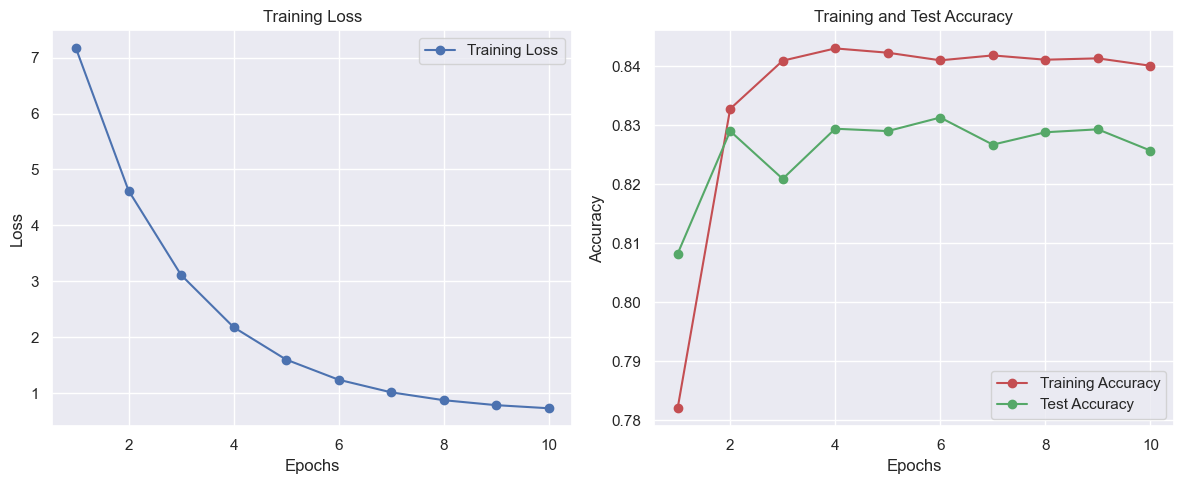

In [90]:
for l in lambda_ranges:
    model = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])
    model.fit(train_loader, test_loader, 0.01, 10, lambda_l2=l)
    model.plot_history()

## 3.4: Unnormalized Images

Epoch 1/20, Loss: 0.8433, Train Accuracy: 0.7317, Test Accuracy: 0.7874
Epoch 2/20, Loss: 0.5468, Train Accuracy: 0.8151, Test Accuracy: 0.8078
Epoch 3/20, Loss: 0.4886, Train Accuracy: 0.8318, Test Accuracy: 0.8254
Epoch 4/20, Loss: 0.4587, Train Accuracy: 0.8406, Test Accuracy: 0.8149
Epoch 5/20, Loss: 0.4380, Train Accuracy: 0.8474, Test Accuracy: 0.8326
Epoch 6/20, Loss: 0.4227, Train Accuracy: 0.8529, Test Accuracy: 0.8396
Epoch 7/20, Loss: 0.4084, Train Accuracy: 0.8577, Test Accuracy: 0.8443
Epoch 8/20, Loss: 0.3990, Train Accuracy: 0.8606, Test Accuracy: 0.8403
Epoch 9/20, Loss: 0.3874, Train Accuracy: 0.8651, Test Accuracy: 0.8411
Epoch 10/20, Loss: 0.3796, Train Accuracy: 0.8653, Test Accuracy: 0.8461
Epoch 11/20, Loss: 0.3708, Train Accuracy: 0.8701, Test Accuracy: 0.8532
Epoch 12/20, Loss: 0.3651, Train Accuracy: 0.8711, Test Accuracy: 0.8546
Epoch 13/20, Loss: 0.3575, Train Accuracy: 0.8742, Test Accuracy: 0.8545
Epoch 14/20, Loss: 0.3511, Train Accuracy: 0.8773, Test Accu

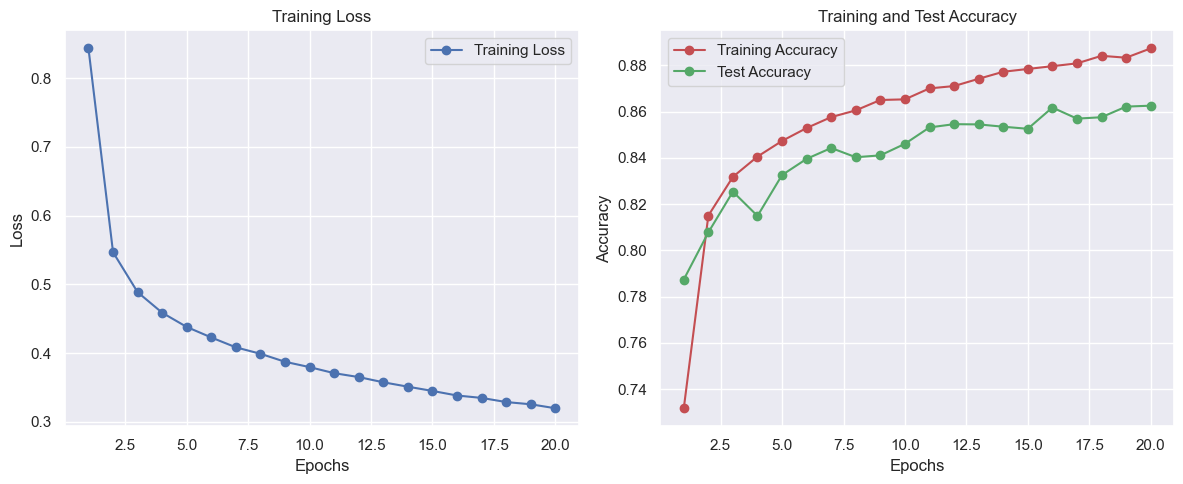

In [ ]:
# q: does unnormalized images just mean without standardization or should we remove also the .toTensor()? 

mlp_transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:x.view(-1))
])

full_train_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_unnormalized)
test_dataset_unnormalized = datasets.FashionMNIST(root='./data', train=False, download=True, transform=mlp_transform_unnormalized)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_unnormalized))
val_size = len(full_train_dataset_unnormalized) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_unnormalized, val_dataset_unnormalized = random_split(full_train_dataset_unnormalized, [train_size, val_size], generator=generator)

# create dataloaders
batch_size = 64
train_loader_unnormalized = DataLoader(train_dataset_unnormalized, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader_unnormalized = DataLoader(val_dataset_unnormalized, batch_size=batch_size, shuffle=False, generator=generator)
test_loader_unnormalized = DataLoader(test_dataset_unnormalized, batch_size=batch_size, shuffle=False, generator=generator)

model_unnormalized = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])

model_unnormalized.fit(train_loader_unnormalized, test_loader_unnormalized, 0.01, 20)
model_unnormalized.plot_history()

## 3.5 MLP with Data Augmentation

Epoch 1/20, Loss: 0.9358, Train Accuracy: 0.6958, Test Accuracy: 0.7689
Epoch 2/20, Loss: 0.6169, Train Accuracy: 0.7894, Test Accuracy: 0.7939
Epoch 3/20, Loss: 0.5494, Train Accuracy: 0.8088, Test Accuracy: 0.8181
Epoch 4/20, Loss: 0.5140, Train Accuracy: 0.8207, Test Accuracy: 0.8108
Epoch 5/20, Loss: 0.4932, Train Accuracy: 0.8269, Test Accuracy: 0.8261
Epoch 6/20, Loss: 0.4739, Train Accuracy: 0.8349, Test Accuracy: 0.8342
Epoch 7/20, Loss: 0.4613, Train Accuracy: 0.8375, Test Accuracy: 0.8352
Epoch 8/20, Loss: 0.4488, Train Accuracy: 0.8426, Test Accuracy: 0.8344
Epoch 9/20, Loss: 0.4372, Train Accuracy: 0.8456, Test Accuracy: 0.8314
Epoch 10/20, Loss: 0.4289, Train Accuracy: 0.8480, Test Accuracy: 0.8403
Epoch 11/20, Loss: 0.4186, Train Accuracy: 0.8537, Test Accuracy: 0.8466
Epoch 12/20, Loss: 0.4148, Train Accuracy: 0.8535, Test Accuracy: 0.8496
Epoch 13/20, Loss: 0.4059, Train Accuracy: 0.8576, Test Accuracy: 0.8446
Epoch 14/20, Loss: 0.3988, Train Accuracy: 0.8596, Test Accu

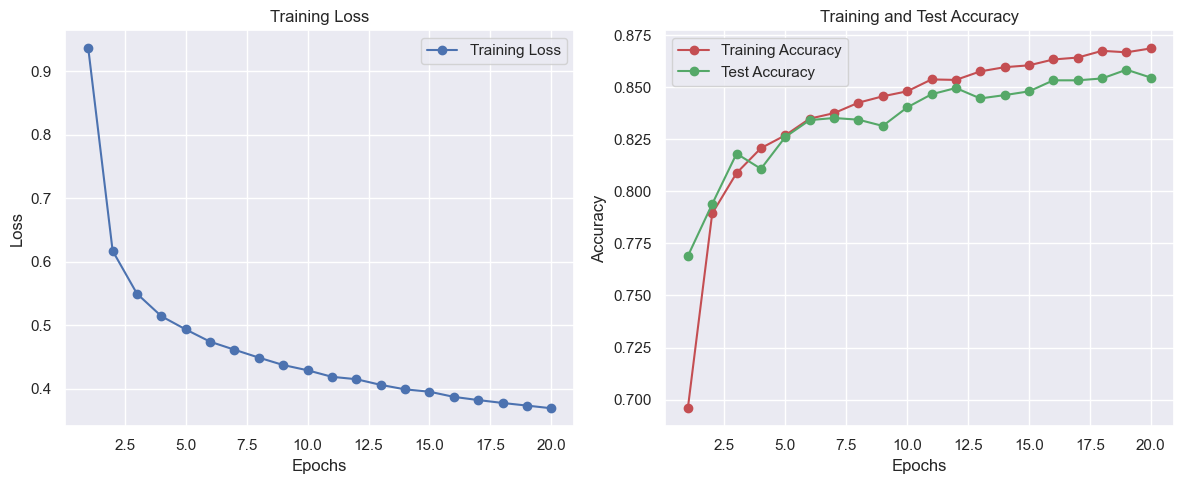

In [ ]:
# q: should the validation set be from the augmented dataset, or from the clean FashionMNIST dataset?

mlp_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    # transforms.RandomCrop(28, padding=2), <- didn't work well :(
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)), 
    transforms.Normalize(mean_train, std_train)
])

full_train_dataset_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=mlp_transform_data_augmentation)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_dataset_data_augmentation))
val_size = len(full_train_dataset_data_augmentation) - train_size

# add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_data_augmentation, val_dataset_data_augmentation = random_split(full_train_dataset_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_data_augmentation = DataLoader(train_dataset_data_augmentation, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader_data_augmentation = DataLoader(val_dataset_data_augmentation, batch_size=batch_size, shuffle=False, generator=generator)

model_data_augmentation = MLP(activation_function=relu(), num_hidden_layers=2, units=[256,256])

model_data_augmentation.fit(train_loader_data_augmentation, test_loader, 0.01, 20)
model_data_augmentation.plot_history()

## 3.6: CNN Using Pytorch

In [9]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: cpu


In [10]:
# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size])

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


### CCN Class

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # 28x28 -> conv -> pool -> 14x14
        # 14x14 -> conv -> pool -> 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # -> 32x14x14
        x = self.pool(self.relu(self.conv2(x)))   # -> 64x7x7

        x = x.view(-1, 64 * 7 * 7)             # flatten

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### CNN Initialization

In [12]:
# Initialize CNN model
learning_rate = 0.001
cnn = CNN().to(device)
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

### CCN Training

In [18]:
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    cnn.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients from previous batch
        
        outputs = cnn(images)
        preds = torch.argmax(outputs, dim=1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn(images)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_correct += (preds == labels).sum().item()
            val_total += len(preds)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Test accuracy (on the full test set)
    cnn.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn(images)
            preds = torch.argmax(outputs, dim=1)

            test_correct += (preds == labels).sum().item()
            test_total += len(preds)
    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train loss={epoch_loss:.4f}, Train acc={epoch_acc*100:.2f}%, Val loss={val_epoch_loss:.4f}, Val acc={val_epoch_acc*100:.2f}%, Test acc={test_acc*100:.2f}%')

end_time = time.time()

Epoch 1/10: Train loss=0.0008, Train acc=98.11%, Val loss=0.0054, Val acc=91.83%, Test acc=91.13%
Epoch 2/10: Train loss=0.0006, Train acc=98.56%, Val loss=0.0054, Val acc=91.88%, Test acc=91.73%
Epoch 3/10: Train loss=0.0006, Train acc=98.70%, Val loss=0.0062, Val acc=90.94%, Test acc=90.40%
Epoch 4/10: Train loss=0.0004, Train acc=99.03%, Val loss=0.0065, Val acc=91.92%, Test acc=91.66%
Epoch 5/10: Train loss=0.0004, Train acc=99.05%, Val loss=0.0067, Val acc=91.89%, Test acc=91.51%
Epoch 6/10: Train loss=0.0004, Train acc=99.13%, Val loss=0.0074, Val acc=91.62%, Test acc=91.06%
Epoch 7/10: Train loss=0.0004, Train acc=99.10%, Val loss=0.0075, Val acc=91.51%, Test acc=91.55%
Epoch 8/10: Train loss=0.0003, Train acc=99.26%, Val loss=0.0070, Val acc=92.19%, Test acc=92.05%
Epoch 9/10: Train loss=0.0003, Train acc=99.44%, Val loss=0.0074, Val acc=92.01%, Test acc=91.68%
Epoch 10/10: Train loss=0.0003, Train acc=99.36%, Val loss=0.0077, Val acc=92.01%, Test acc=91.60%


### Plot results

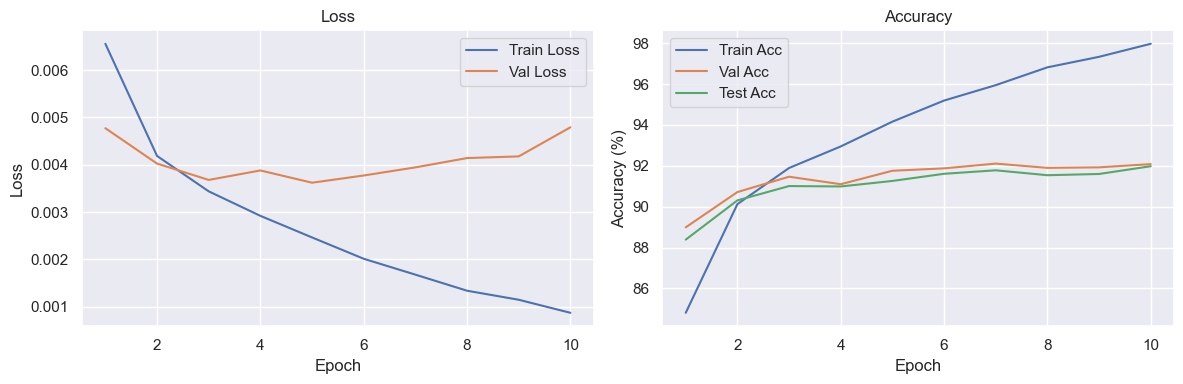

In [14]:
# Plot training/validation history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies], label='Train Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies], label='Val Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


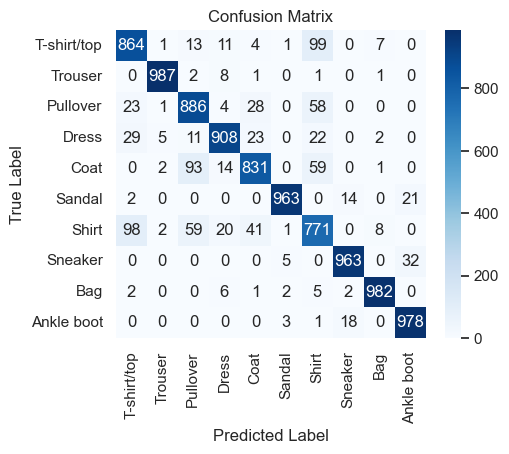

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cnn.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = cnn(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.7: CNN with Data Augmentation

In [19]:
cnn_transform_data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train)
])

full_train_cnn_data_augmentation = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform_data_augmentation)
# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn_data_augmentation))
val_size = len(full_train_cnn_data_augmentation) - train_size
# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn_data_augmentation, val_dataset_cnn_data_augmentation = random_split(full_train_cnn_data_augmentation, [train_size, val_size], generator=generator)

batch_size = 64
train_loader_cnn_data_augmentation = DataLoader(train_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=True)
val_loader_cnn_data_augmentation = DataLoader(val_dataset_cnn_data_augmentation, batch_size=batch_size, shuffle=False)
test_loader_cnn_data_augmentation = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

cnn_aug = CNN().to(device)
optimizer = optim.Adam(cnn_aug.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# train CNN 
num_epochs = 10
train_losses_aug = []
train_accuracies_aug = []
val_losses_aug = []
val_accuracies_aug = []
test_accuracies_aug = []
start_time_aug = time.time()

for epoch in range(num_epochs):
    cnn_aug.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cnn_data_augmentation:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients from previous batch
        
        outputs = cnn_aug(images)
        preds = torch.argmax(outputs, dim=1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses_aug.append(epoch_loss)
    train_accuracies_aug.append(epoch_acc)

    # Validation
    cnn_aug.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn_data_augmentation:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_aug(images)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_correct += (preds == labels).sum().item()
            val_total += len(preds)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses_aug.append(val_epoch_loss)
    val_accuracies_aug.append(val_epoch_acc)

    # Test accuracy (on the full test set)
    cnn_aug.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn_data_augmentation:
            images, labels = images.to(device), labels.to(device)
            
            outputs = cnn_aug(images)
            preds = torch.argmax(outputs, dim=1)

            test_correct += (preds == labels).sum().item()
            test_total += len(preds)
    test_acc = test_correct / test_total
    test_accuracies_aug.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train loss={epoch_loss:.4f}, Train acc={epoch_acc*100:.2f}%, Val loss={val_epoch_loss:.4f}, Val acc={val_epoch_acc*100:.2f}%, Test acc={test_acc*100:.2f}%')

end_time_aug = time.time()

Epoch 1/10: Train loss=0.0071, Train acc=83.35%, Val loss=0.0057, Val acc=86.62%, Test acc=86.03%
Epoch 2/10: Train loss=0.0047, Train acc=89.05%, Val loss=0.0043, Val acc=90.12%, Test acc=89.92%
Epoch 3/10: Train loss=0.0040, Train acc=90.57%, Val loss=0.0042, Val acc=90.20%, Test acc=90.20%
Epoch 4/10: Train loss=0.0036, Train acc=91.56%, Val loss=0.0041, Val acc=90.56%, Test acc=90.74%
Epoch 5/10: Train loss=0.0032, Train acc=92.39%, Val loss=0.0037, Val acc=91.27%, Test acc=91.06%
Epoch 6/10: Train loss=0.0029, Train acc=93.00%, Val loss=0.0035, Val acc=91.92%, Test acc=91.88%
Epoch 7/10: Train loss=0.0027, Train acc=93.57%, Val loss=0.0040, Val acc=90.94%, Test acc=91.23%
Epoch 8/10: Train loss=0.0025, Train acc=93.96%, Val loss=0.0036, Val acc=91.77%, Test acc=91.95%
Epoch 9/10: Train loss=0.0023, Train acc=94.47%, Val loss=0.0037, Val acc=91.78%, Test acc=91.92%
Epoch 10/10: Train loss=0.0021, Train acc=94.94%, Val loss=0.0036, Val acc=92.20%, Test acc=91.54%


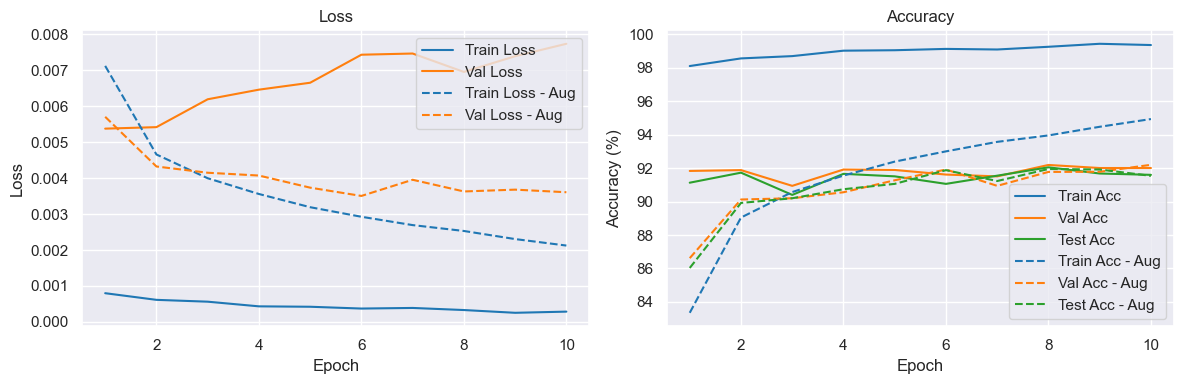

Training time without augmentation: 340.63 seconds
Training time with augmentation: 392.03 seconds


In [22]:
# Plot training/validation history of augmented CNN on top of original CNN
plt.figure(figsize=(12,4))
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color=colors[0])
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss', color=colors[1])
plt.plot(range(1, num_epochs+1), train_losses_aug, label='Train Loss - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, num_epochs+1), val_losses_aug, label='Val Loss - Aug', linestyle='--', color=colors[1])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies], label='Train Acc', color=colors[0])
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies], label='Val Acc', color=colors[1])
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], label='Test Acc', color=colors[2])
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies_aug], label='Train Acc - Aug', linestyle='--', color=colors[0])
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies_aug], label='Val Acc - Aug', linestyle='--', color=colors[1])
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies_aug], label='Test Acc - Aug', linestyle ='--', color=colors[2])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare training times
print(f"Training time without augmentation: {end_time - start_time:.2f} seconds")
print(f"Training time with augmentation: {end_time_aug - start_time_aug:.2f} seconds")

## 3.8: Pretrained ResNet 